In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pygments.styles import native

# Konwersja danych tekstowych na liczbowe
from sklearn import preprocessing

# Podział na podzbiory
from sklearn.model_selection import train_test_split

# Normalizacja danych
from sklearn.preprocessing import MinMaxScaler

# KNN
from sklearn.neighbors import KNeighborsClassifier

# Ocena algorytmów
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

Wczytywanie danych

In [54]:
df = pd.read_csv("adult.csv")
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Eksploracja danych

In [55]:
df.info()
print(f"Liczba duplikatów: {df.duplicated().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
Liczba duplikatów: 24


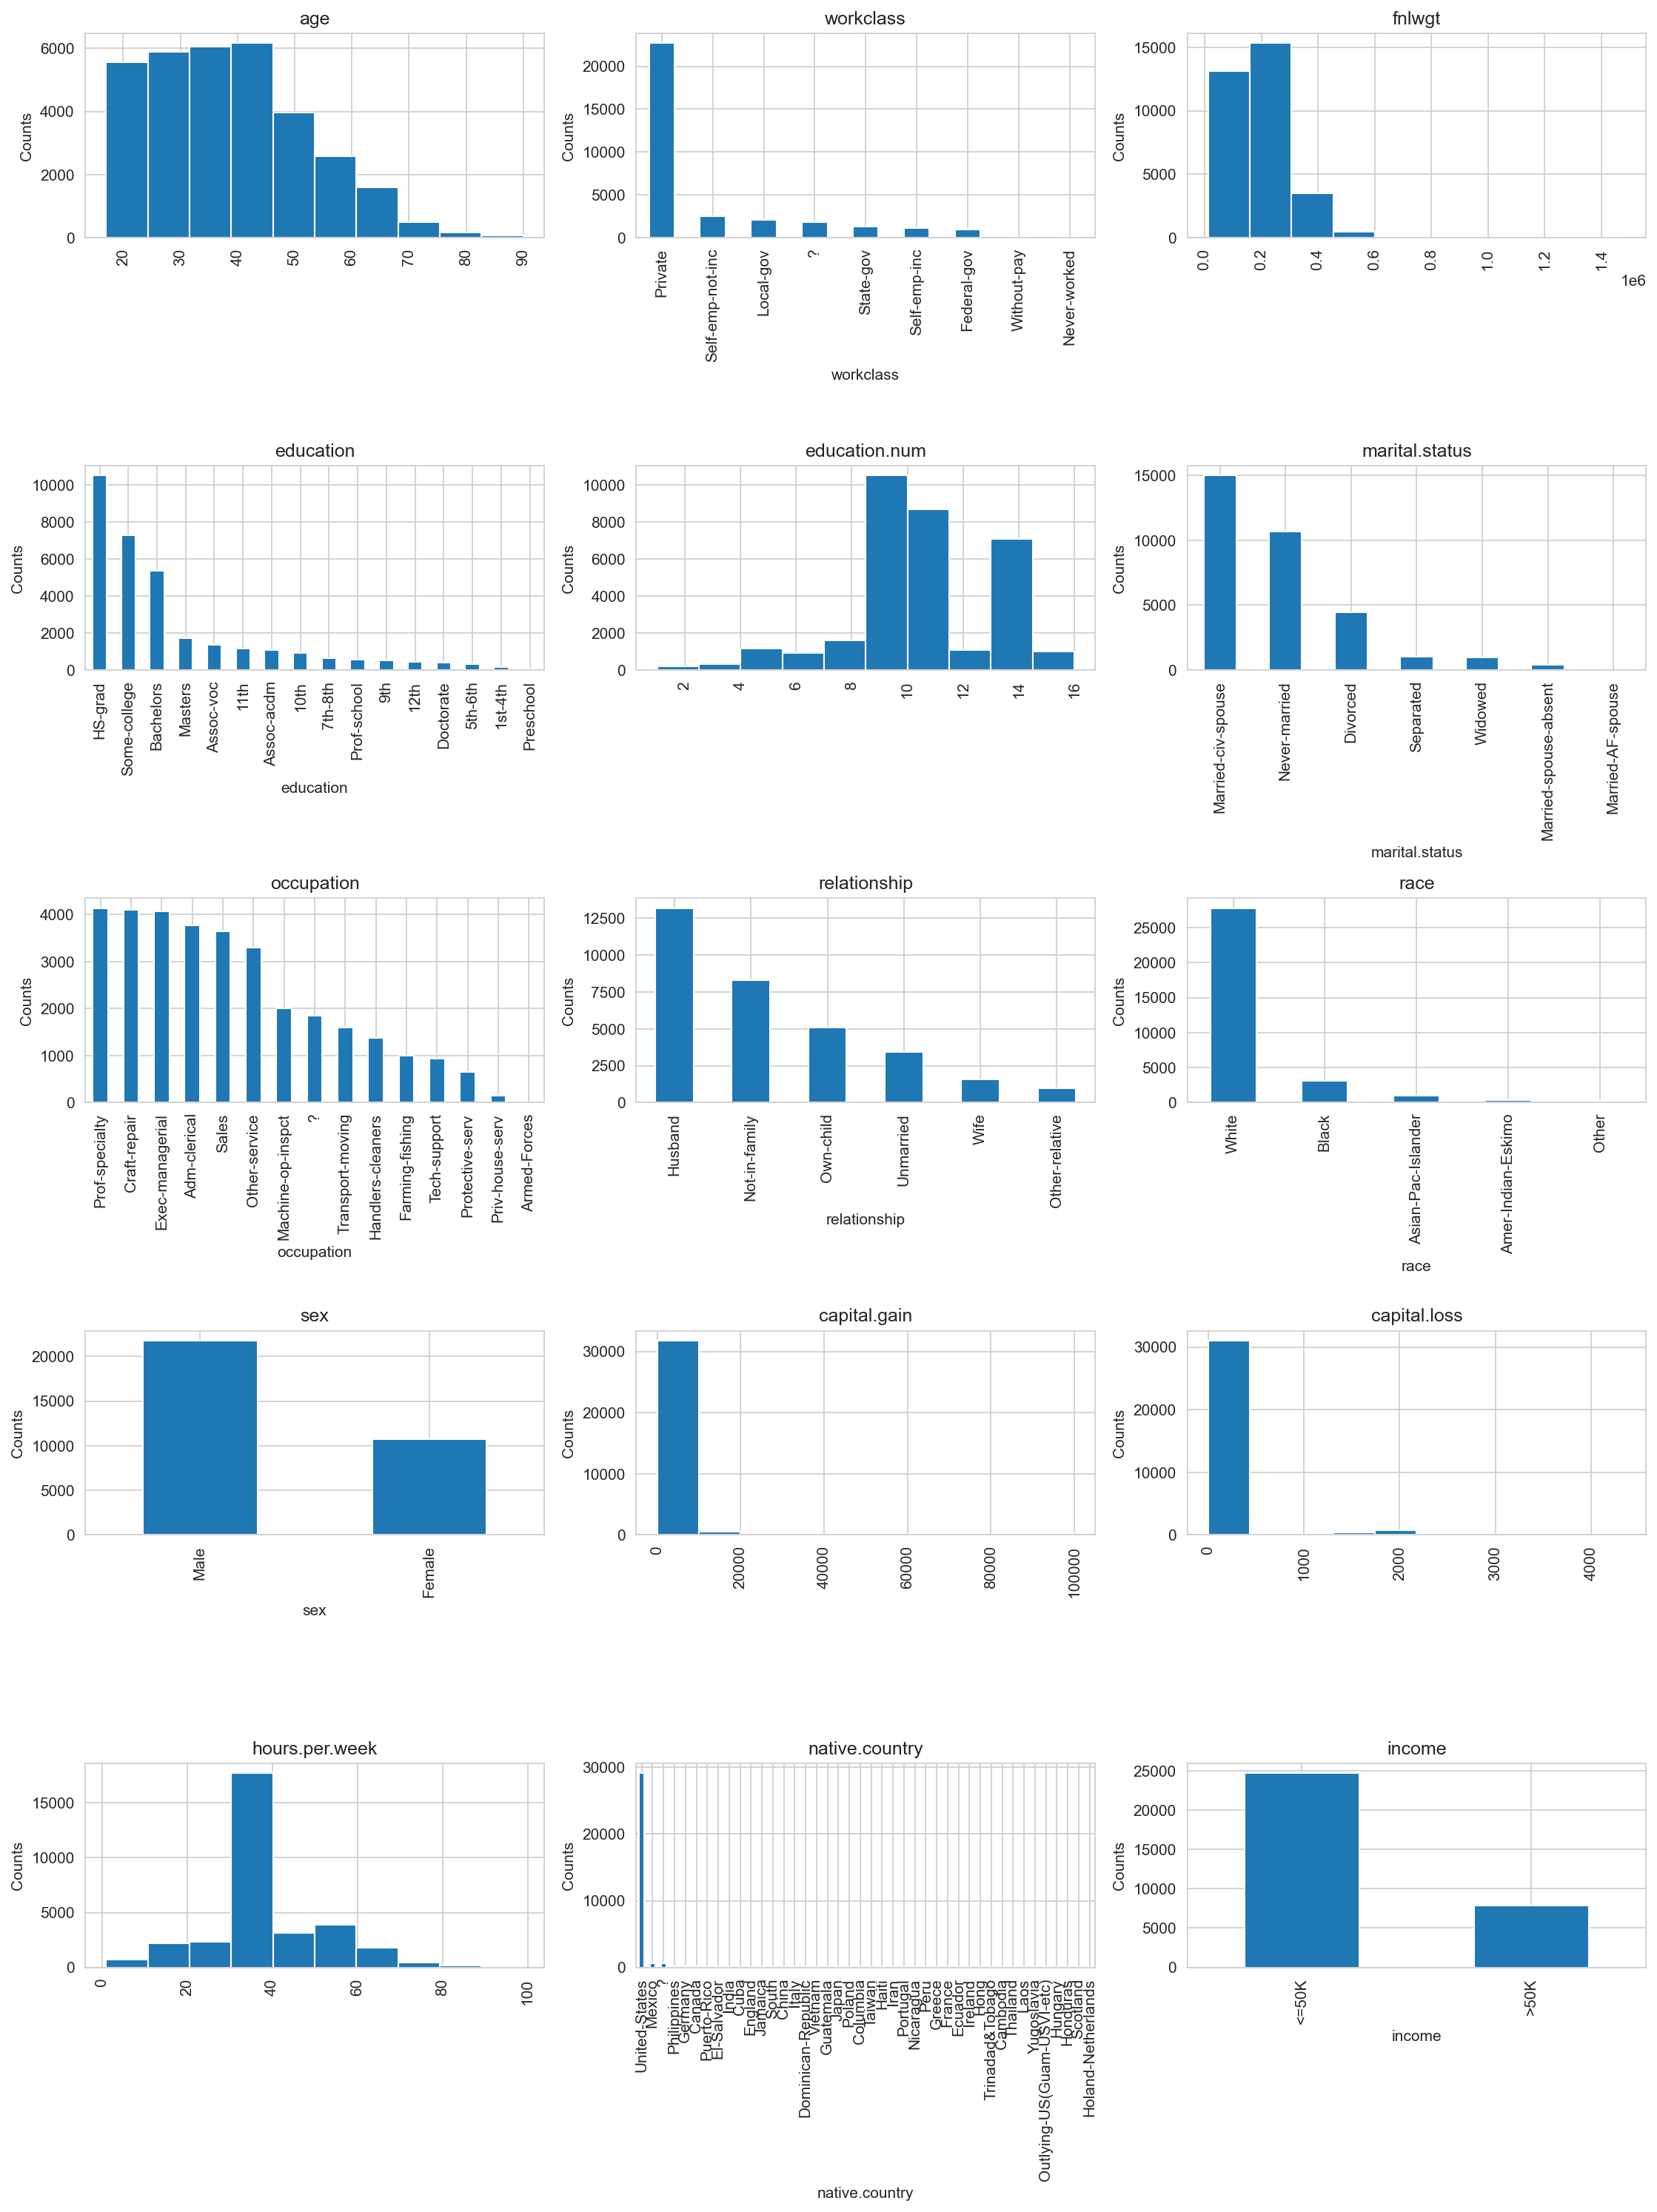

In [56]:
# Dystrybucja danych - wykresy
def CreateDistributionGraphs(dataframe, graphsperrow):
    # Filter out columns based on the number of unique values
    nunique = dataframe.nunique()
    dataframe = dataframe.loc[:, nunique > 1]  # Keep columns with more than 1 unique value
    
    colnames = list(dataframe.columns)
    num_of_graphs = len(colnames)
    
    # Calculate number of rows needed to display all graphs
    nrows = (num_of_graphs + graphsperrow - 1) // graphsperrow  # Use integer division
    
    # Create a figure with appropriate size
    plt.figure(figsize=(5 * graphsperrow, 4 * nrows), dpi=150)
    
    # Plot each column as a separate subplot
    for i in range(num_of_graphs):
        plt.subplot(nrows, graphsperrow, i + 1)
        col_df = dataframe.iloc[:, i]
        
        # Check if column data type is numeric
        if np.issubdtype(col_df.dtype, np.number):
            col_df.hist()
        else:
            value_counts = col_df.value_counts()
            value_counts.plot.bar()
        
        plt.ylabel('Counts')
        plt.xticks(rotation=90)
        plt.title(f'{colnames[i]}')
    
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()
        
    
# Wykresy danych uzupełnionych
CreateDistributionGraphs(df, 3) 

In [57]:
# Usunięcie kolumn niezbalansowanych
df.drop(labels=['capital.gain', 'capital.loss', 'native.country'], axis=1, inplace=True)
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32534 entries, 0 to 32560
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32534 non-null  int64 
 1   workclass       32534 non-null  object
 2   fnlwgt          32534 non-null  int64 
 3   education       32534 non-null  object
 4   education.num   32534 non-null  int64 
 5   marital.status  32534 non-null  object
 6   occupation      32534 non-null  object
 7   relationship    32534 non-null  object
 8   race            32534 non-null  object
 9   sex             32534 non-null  object
 10  hours.per.week  32534 non-null  int64 
 11  income          32534 non-null  object
dtypes: int64(4), object(8)
memory usage: 3.2+ MB


In [58]:
df[df == '?'] = np.nan
cols_with_missing_values = df.isnull().sum() 
print(cols_with_missing_values[cols_with_missing_values > 0])
# Pozostały 2 kolumny zawierające puste wartości

workclass     1836
occupation    1843
dtype: int64


Zamiana pustych wartości na wartości najpopularniejsze

In [59]:
df_filled = df.copy()
for col in ["workclass", "occupation"]:
    mode_value = df_filled[col].mode()[0]  # Obliczenie mody dla kolumny
    df_filled.loc[df_filled[col].isnull(), col] = mode_value  # Wypełnienie pustych wartości modą

df_filled.head(10)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,hours.per.week,income
0,90,Private,77053,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,40,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,18,<=50K
2,66,Private,186061,Some-college,10,Widowed,Prof-specialty,Unmarried,Black,Female,40,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,40,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,40,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,45,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,40,<=50K
7,74,State-gov,88638,Doctorate,16,Never-married,Prof-specialty,Other-relative,White,Female,20,>50K
8,68,Federal-gov,422013,HS-grad,9,Divorced,Prof-specialty,Not-in-family,White,Female,40,<=50K
9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,60,>50K


In [60]:
df.dropna(inplace=True)
df.info()
# Usunięto prawie 2.5k rekordów

<class 'pandas.core.frame.DataFrame'>
Index: 30691 entries, 1 to 32560
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30691 non-null  int64 
 1   workclass       30691 non-null  object
 2   fnlwgt          30691 non-null  int64 
 3   education       30691 non-null  object
 4   education.num   30691 non-null  int64 
 5   marital.status  30691 non-null  object
 6   occupation      30691 non-null  object
 7   relationship    30691 non-null  object
 8   race            30691 non-null  object
 9   sex             30691 non-null  object
 10  hours.per.week  30691 non-null  int64 
 11  income          30691 non-null  object
dtypes: int64(4), object(8)
memory usage: 3.0+ MB


Korelacja danych numerycznych

In [61]:
# Zamiana wartości w kolumnie wynikowej
df_filled["income"] = df_filled["income"].map({">50K" : 1, "<=50K" : 0})
df_filled.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,hours.per.week,income
0,90,Private,77053,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,40,0
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,18,0
2,66,Private,186061,Some-college,10,Widowed,Prof-specialty,Unmarried,Black,Female,40,0
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,40,0
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,40,0


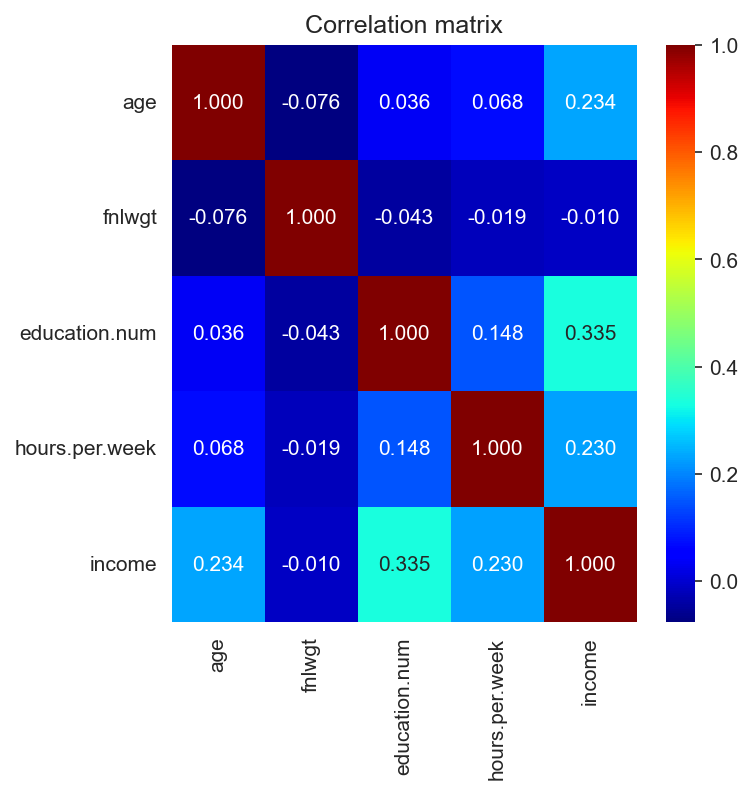

In [62]:
text_cols = ["workclass", "education", "marital.status", "occupation", "relationship", "race", "sex"]
corr_matrix = df_filled.drop(labels=text_cols, axis=1).corr()
plt.figure(figsize=(5,5), dpi=150)
sns.heatmap(corr_matrix, annot=True, cmap="jet", fmt=".3f")
plt.title("Correlation matrix")
plt.show()

Kodowanie kolumn kategorycznych na numeryczne

In [63]:
encoder = preprocessing.LabelEncoder()
for col in text_cols:
    df_filled[col] = encoder.fit_transform(df_filled[col])
df_filled.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,hours.per.week,income
0,90,3,77053,11,9,6,9,1,4,0,40,0
1,82,3,132870,11,9,6,3,1,4,0,18,0
2,66,3,186061,15,10,6,9,4,2,0,40,0
3,54,3,140359,5,4,0,6,4,4,0,40,0
4,41,3,264663,15,10,5,9,3,4,0,40,0


Korelacja danych po kodowaniu

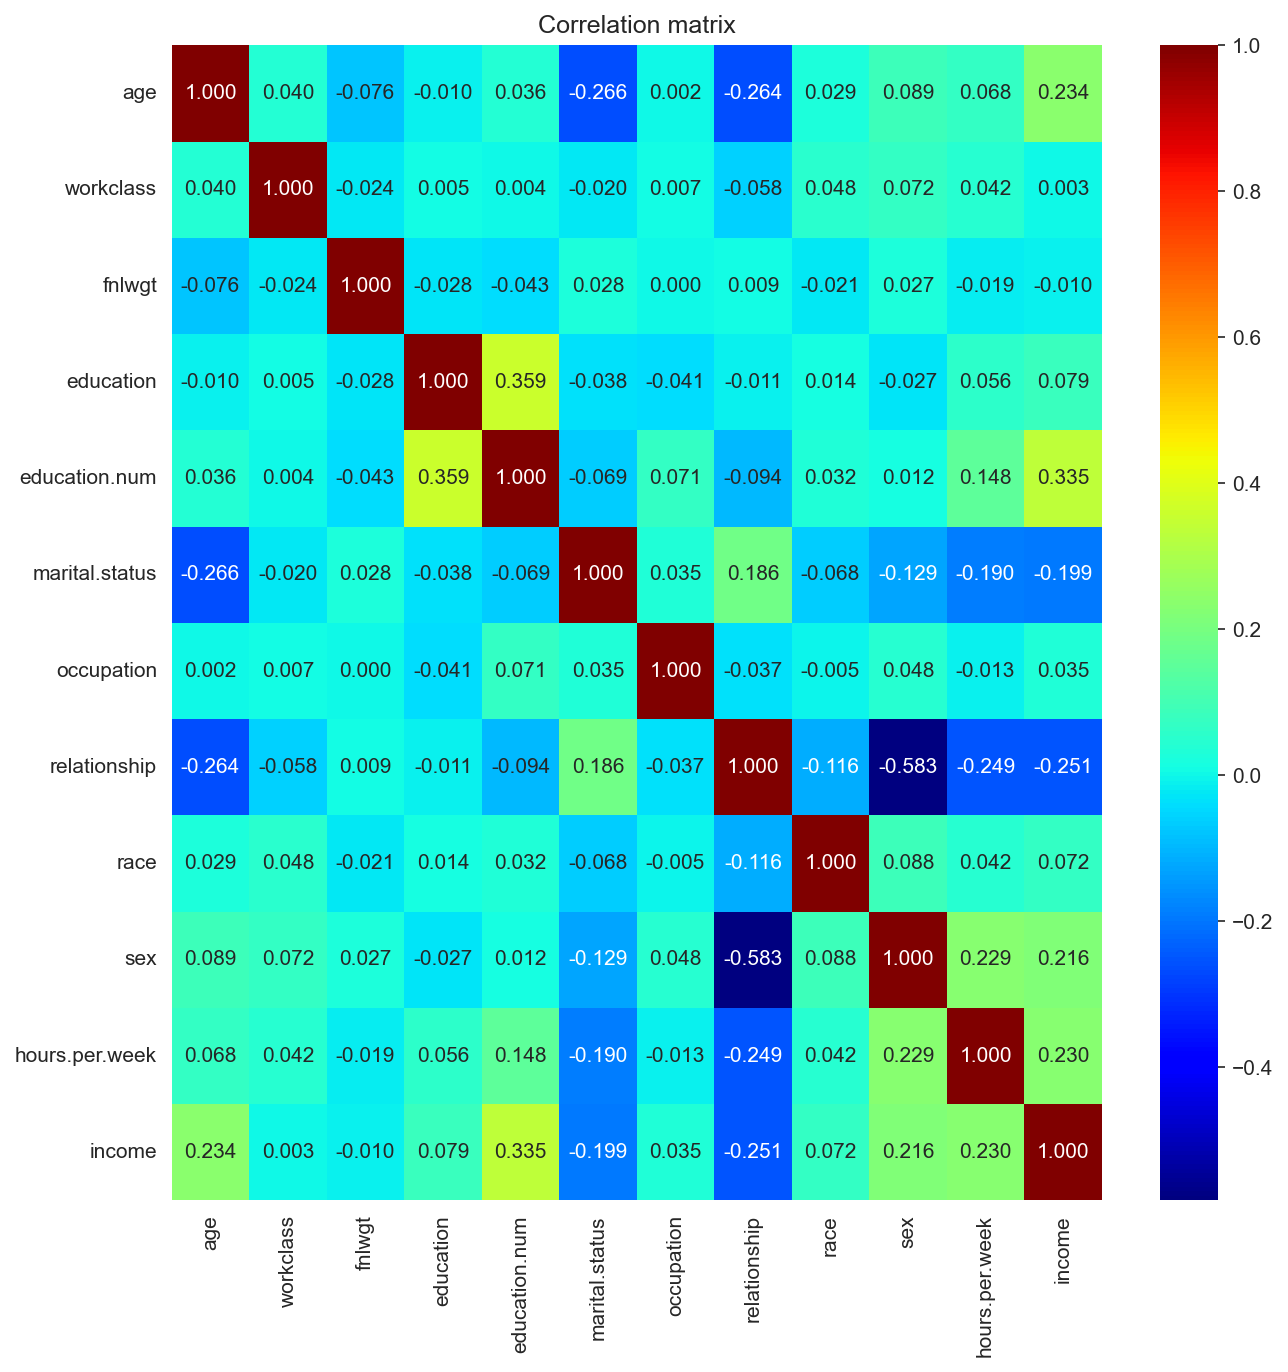

In [64]:
plt.figure(figsize=(10,10), dpi=150)
sns.heatmap(df_filled.corr(), annot=True, cmap="jet", fmt=".3f")
plt.title("Correlation matrix")
plt.show()

Klasyfikator naiwny Bayesa, funkcja gęstości Gaussa

In [65]:
class NaiveBayes():
    def __init__(self):
        self.mean = {}              # Średnie klas
        self.var = {}               # Wariancje klas
        self.class_prior = {}       # Prawdopodobieństwa prior klas - prawdopodobieństwo wylosowania elementu klasy z całości tabeli
        
    def fit(self, X_train, y_train):
        self.classes = np.unique(y_train)                   # Znalezienie unikalnych wartości y -> ilość różnych klas
        for cls in self.classes:
            X_c = X_train[y_train == cls]                   # Utworzenie tymczasowego podzbioru X'ów należących do tej samej klasy
            self.class_prior[cls] = len(X_c)/len(X_train)   # Obliczenie prawdopodobieństwa prior
            self.mean[cls] = np.mean(X_c, axis=0)           # Obliczenie średniej wszystkich rekordów dla każdej z kolumn (axis=0)
            self.var[cls] = np.var(X_c, axis=0)             # Obliczenie wariancji wszystkich rekordów dla każdej z kolumn (axis=0)
            
    def gauss(self, x, mean, var):                          # Funkcja gęstości Gaussa 
        exponent = np.exp(-(x - mean) ** 2 / (2 * var))
        return 1/np.sqrt(2 * np.pi * var) * exponent
            
    def calculate_posterior(self, x):
        posteriors = {}
        for cls in self.classes:
            # Normalizacja funkcją logarytmiczną - przyspiesza obliczenia
            prob = np.sum(np.log(self.gauss(x, self.mean[cls], self.var[cls])))
            posteriors[cls] = np.log(self.class_prior[cls]) + prob
        return posteriors
            
    def predict(self, X_test):
        predictions = []
        for x in X_test.values:
            prob = self.calculate_posterior(x)              # Obliczenie posteriora dla każdej z klas
            predictions.append(max(prob, key=prob.get))     # Dodanie x do klasy o najwyższym współczynniku posterior
        return predictions
    
    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = sum(y_test == y_pred) / len(y_test)
        return accuracy
    
    
NB_classifier = NaiveBayes()

Klasyfikator KNN, metryka euklidesowa

In [66]:
class KNN:
    def __init__(self, k_neighbors=3):
        self.k_neighbors = k_neighbors
        
    # Metryka obliczania odległości
    def __distance_metric(self, point, data):
        return np.sqrt(np.sum((data - point) ** 2, axis=1))        
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    def predict(self, X_test):
        predictions = []
        for x in X_test.values:
            # Wyliczanie odległości pomiędzy X'ami testowanymi a X'ami treningowymi
            distances = self.__distance_metric(x, self.X_train)
            
            # Sortowanie odległości, wybór k najmniejszych wartości (indeksów tych wartości)
            indices = np.argsort(distances)[:self.k_neighbors]
            
            # Plebiscyt - dodanie do grupy z największą liczbą głosów
            labels = [self.y_train.iloc[i] for i in indices]
            result = max(set(labels), key=labels.count)
            
            # Dodanie do predictions
            predictions.append(result)
        
        return predictions
    
    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = sum(y_test == y_pred) / len(y_test)
        return accuracy

KNN_classifier = KNN(5)

Zbiór po uzupełnieniu danych niekompletnych o wartości najpopularniejsze w określonej kolumnnie

In [67]:
results = {}
scaler = MinMaxScaler()

y_filled = df_filled.pop("income")
X_filled = df_filled
X_train, X_test, y_train, y_test = train_test_split(X_filled, y_filled, test_size=int(30_000*.3), train_size=int(30_000*.7))

NB_classifier.fit(X_train, y_train)
# nb_score = NB_classifier.score(X_test, y_test)
results['NB_filled'] = (NB_classifier.predict(X_test), y_test)

KNN_classifier.fit(X_train, y_train)
# knn_score = KNN_classifier.score(X_test, y_test)
results['KNN_filled'] = (KNN_classifier.predict(X_test), y_test)

# print(f"Before scaling:")
# print(f"NB Score: {nb_score}    KNN Score: {knn_score}\n")
print("Unscaled filled done.")


scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
scaler.fit(X_test)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

NB_classifier.fit(X_train_scaled, y_train)
# nb_score = NB_classifier.score(X_test_scaled, y_test)
results['NB_filled_scaled'] = (NB_classifier.predict(X_test_scaled), y_test)


KNN_classifier.fit(X_train_scaled, y_train)
# knn_score = KNN_classifier.score(X_test_scaled, y_test)
results['KNN_filled_scaled'] = (KNN_classifier.predict(X_test_scaled), y_test)

# print("After scaling:")
# print(f"NB Score: {nb_score}    KNN Score: {knn_score}")
print("Scaled filled done.")

Unscaled filled done.
Scaled filled done.


Zbiór po usunięciu danych niekompletnych

In [68]:
for col in text_cols:
    df[col] = encoder.fit_transform(df[col])
df["income"] = df["income"].map({">50K" : 1, "<=50K" : 0})
    
y_reduced = df.pop("income")
X_reduced = df
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_reduced, test_size=int(30_000*.3), train_size=int(30_000*.7))

NB_classifier.fit(X_train, y_train)
# nb_score = NB_classifier.score(X_test, y_test)
results['NB_reduced'] = (NB_classifier.predict(X_test), y_test)

KNN_classifier.fit(X_train, y_train)
# knn_score = KNN_classifier.score(X_test, y_test)
results['KNN_reduced'] = (KNN_classifier.predict(X_test), y_test)

# print(f"Before scaling:")
# print(f"NB Score: {nb_score}    KNN Score: {knn_score}\n")
print("Unscaled reduced done.")


scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
scaler.fit(X_test)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

NB_classifier.fit(X_train_scaled, y_train)
# nb_score = NB_classifier.score(X_test_scaled, y_test)
results['NB_reduced_scaled'] = (NB_classifier.predict(X_test_scaled), y_test)


KNN_classifier.fit(X_train_scaled, y_train)
# knn_score = KNN_classifier.score(X_test_scaled, y_test)
results['KNN_reduced_scaled'] = (KNN_classifier.predict(X_test_scaled), y_test)

# print(f"After scaling:")
# print(f"NB Score: {nb_score}    KNN Score: {knn_score}")
print("Scaled reduced done.")

Unscaled reduced done.
Scaled reduced done.


In [69]:
def PrintMetrics(results):
    for method, result in results.items():
        y_pred, y_true = result
        print(f"{method}:")
        print(f"Accuracy: {accuracy_score(y_pred, y_true)}")
        print(f"Precision: {precision_score(y_pred, y_true)}")
        print(f"Recall: {recall_score(y_pred, y_true)}")
        print(f"F1: {f1_score(y_pred, y_true)}")
        print(f"Confusion Matrix: {confusion_matrix(y_pred, y_true)}\n\n")
    
PrintMetrics(results)   

NB_filled:
Accuracy: 0.7775555555555556
Precision: 0.7154658100045893
Recall: 0.5300918055083305
F1: 0.608984375
Confusion Matrix: [[5439  620]
 [1382 1559]]


KNN_filled:
Accuracy: 0.7251111111111112
Precision: 0.18494722349701698
Recall: 0.36603088101725706
F1: 0.24573170731707317
Confusion Matrix: [[6123 1776]
 [ 698  403]]


NB_filled_scaled:
Accuracy: 0.778
Precision: 0.7150068838916934
Recall: 0.5308347529812606
F1: 0.6093077825576848
Confusion Matrix: [[5444  621]
 [1377 1558]]


KNN_filled_scaled:
Accuracy: 0.8138888888888889
Precision: 0.5745754933455713
Recall: 0.626
F1: 0.5991864082316344
Confusion Matrix: [[6073  927]
 [ 748 1252]]


NB_reduced:
Accuracy: 0.7752222222222223
Precision: 0.7150537634408602
Recall: 0.535031847133758
F1: 0.6120805369127517
Confusion Matrix: [[5381  636]
 [1387 1596]]


KNN_reduced:
Accuracy: 0.7101111111111111
Precision: 0.19668458781362008
Recall: 0.349800796812749
F1: 0.2517923716661887
Confusion Matrix: [[5952 1793]
 [ 816  439]]


NB_reduced

Znajdowanie najlepszego k dla danych uzupełnionych

In [70]:
scores = []
scores_overall = {}
prev_mean_score = 0

# Skalowanie zbioru
X_filled = pd.DataFrame(scaler.transform(X_filled), columns=X_filled.columns, index=X_filled.index)

for k in range(1, 51):
    print(f"Testing for k={k}:\n")
    KNN_classifier = KNeighborsClassifier(k, n_jobs=-1)
    for _ in range(30):
        X_train, X_test, y_train, y_test = train_test_split(X_filled, y_filled, test_size=int(30_000*.3), train_size=int(30_000*.7))
        KNN_classifier.fit(X_train, y_train)
        scores.append(KNN_classifier.score(X_test, y_test))
        print(f"{scores[-1]:.4f}, ", end="")
    current_mean_score = np.mean(scores)
    print(f"AVG: {current_mean_score}\n")
    scores = []
    scores_overall[k] = current_mean_score
print(f"Best score: {max(scores_overall.values())}, for k={max(scores_overall, key=lambda k: scores_overall[k])}")

Testing for k=1:
0.7878, 0.7858, 0.7878, 0.7828, 0.7722, 0.7768, 0.7781, 0.7810, 0.7817, 0.7869, 0.7766, 0.7770, 0.7790, 0.7884, 0.7824, 0.7813, 0.7774, 0.7806, 0.7841, 0.7831, 0.7770, 0.7898, 0.7767, 0.7848, 0.7796, 0.7808, 0.7766, 0.7782, 0.7764, 0.7796, AVG: 0.7810037037037036

Testing for k=2:
0.8094, 0.8034, 0.8088, 0.7928, 0.7971, 0.8003, 0.7961, 0.8014, 0.7948, 0.7989, 0.8019, 0.7942, 0.8051, 0.8081, 0.8037, 0.7998, 0.8006, 0.7983, 0.7982, 0.8041, 0.7996, 0.7990, 0.8002, 0.7992, 0.7986, 0.7976, 0.8011, 0.8019, 0.8058, 0.7966, AVG: 0.8005518518518518

Testing for k=3:
0.8026, 0.8044, 0.8118, 0.8086, 0.8058, 0.8030, 0.8083, 0.8072, 0.8089, 0.8058, 0.8072, 0.8101, 0.8068, 0.8091, 0.8016, 0.8072, 0.8104, 0.8103, 0.8058, 0.8038, 0.8019, 0.8021, 0.8061, 0.8076, 0.8121, 0.8151, 0.8130, 0.8071, 0.8108, 0.8036, AVG: 0.8072666666666666

Testing for k=4:
0.8136, 0.8158, 0.8147, 0.8142, 0.8150, 0.8087, 0.8154, 0.8134, 0.8169, 0.8127, 0.8154, 0.8154, 0.8180, 0.8083, 0.8177, 0.8168, 0.8123, 0

1: 0.7810037037037036
2: 0.8005518518518518
3: 0.8072666666666666
4: 0.814862962962963
5: 0.8179629629629629
6: 0.8228851851851852
7: 0.8226851851851852
8: 0.8252407407407406
9: 0.8244296296296297
10: 0.8274851851851852
11: 0.8272333333333333
12: 0.8278370370370369
13: 0.8276222222222223
14: 0.8294925925925926
15: 0.8290444444444444
16: 0.8282148148148148
17: 0.8290777777777778
18: 0.8302148148148148
19: 0.8294333333333334
20: 0.8300222222222221
21: 0.8283814814814817
22: 0.8292888888888886
23: 0.8303481481481481
24: 0.8300333333333333
25: 0.8294814814814816
26: 0.830048148148148
27: 0.829725925925926
28: 0.8305962962962964
29: 0.8294074074074073
30: 0.8302703703703703
31: 0.8291296296296297
32: 0.8295592592592592
33: 0.8292703703703703
34: 0.8298592592592594
35: 0.8291148148148149
36: 0.8287
37: 0.8299481481481481
38: 0.8292851851851852
39: 0.8279777777777776
40: 0.8294370370370371
41: 0.8285185185185188
42: 0.8293592592592595
43: 0.8288814814814814
44: 0.8298148148148149
45: 0.829133

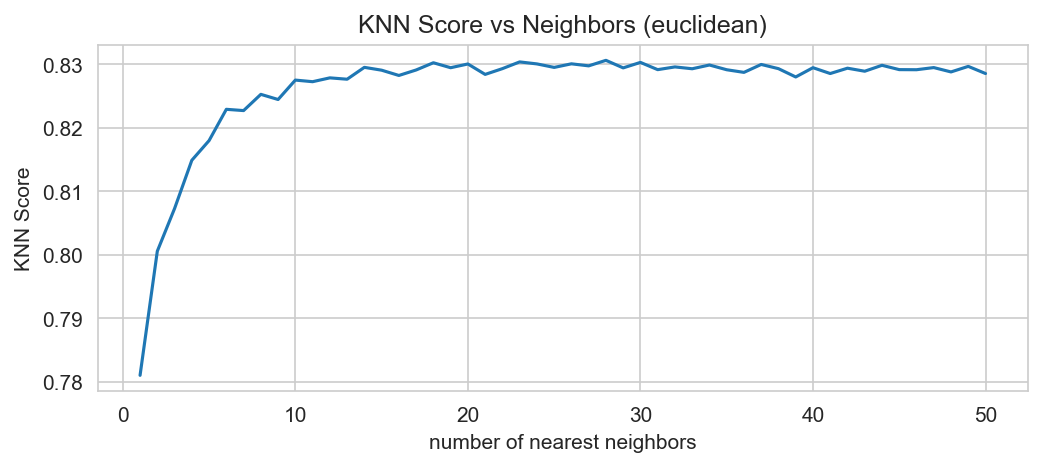

In [71]:
sorted_scores = sorted(scores_overall.items())
for k, v in sorted_scores:
    print(f"{k}: {v}")
neighbors_x, neighbors_y = zip(*sorted_scores)
plt.figure(figsize=(8,3), dpi=150)
plt.plot(neighbors_x, neighbors_y)
plt.title("KNN Score vs Neighbors (euclidean)")
plt.xlabel("number of nearest neighbors")
plt.ylabel("KNN Score")
plt.show()